# DR. Potato - Potato Disease Classification

## Import all the Dependencies

In [1]:
#importing dependencies
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt 

c:\users\saisu\appdata\local\programs\python\python39\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\users\saisu\appdata\local\programs\python\python39\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
c:\users\saisu\appdata\local\programs\python\python39\lib\site-packages\numpy\.libs\libopenblas.GK7GX5KEQ4F6UYO3P26ULGBQYHGQO7J4.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


## See all the constants

In [2]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50

## Initializing, Exploring & Partioning the Dataset

### Reading and Partitioning the Dataset
We create a Tensorflow Dataset Object and directly read it from the directory using image_dataset_from_directory and then split it using the function we created above

In [3]:
#load all images into dataset
dataset = tf.keras.preprocessing.image_dataset_from_directory(
	"PlantVillage",
	shuffle = True,
	image_size = (IMAGE_SIZE,IMAGE_SIZE),
	batch_size = BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


### Checking the Available Classes

In [4]:
class_names = dataset.class_names
class_names


['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [5]:
#every element in the dataset is a batch of 32 
len(dataset)

68

### Displaying Some Sample Images

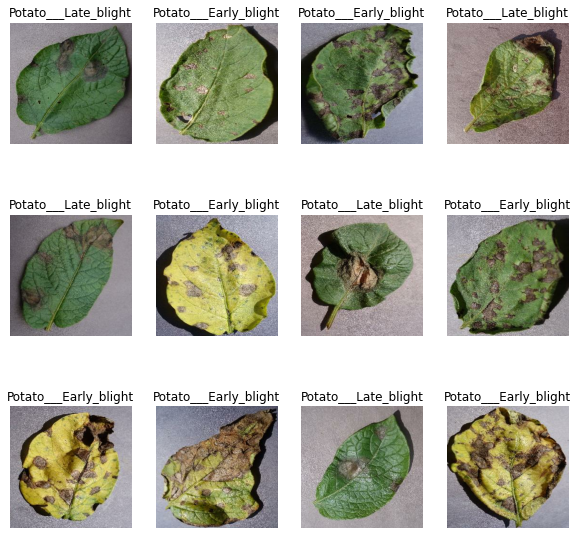

In [6]:
# 3 in output is rgb channels
plt.figure(figsize = (10,10))
for image_batch,label_batch in dataset.take(1):
    #print(image_batch[0].numpy())
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")
    #print(image_batch.shape)  
    #print(label_batch.numpy()) #convert tensor into numpy

### Function to Split Dataset
Dataset should be bifurcated into 3 subsets, namely:

- Training: Dataset to be used while training
- Validation: Dataset to be tested against while training
- Test: Dataset to be tested against after we trained a model

In [7]:
# 80% training data, 10% validation set, 10% test set
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [8]:
train_ds = dataset.take(54) #take first 54 batches
len(train_ds)

54

In [9]:
test_ds = dataset.skip(54) #skip first 54 batches and get next 54 
len(test_ds)

14

In [10]:
val_size  = 0.1
len(dataset)*val_size

6.800000000000001

In [11]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [12]:
test_ds = test_ds.skip(6)
len(test_ds)

8

In [13]:
def get_dataset_partitions_tf(ds,train_split = 0.8,val_split = 0.1,test_split = 0.1, shuffle = True, shuffle_size = 10000):
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed = 12)
    
    train_size = int(train_split*ds_size)
    val_size = int(val_split*ds_size)
    train_ds = ds.take(train_size)
    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    return train_ds, val_ds, test_ds

In [14]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [15]:
len(train_ds)

54

In [16]:
len(val_ds)

6

In [17]:
len(test_ds)

8

### Cache, Shuffle, and Prefetch the Dataset

In [18]:
#caching - read image from disk and for next iteration it keeps image in the memory, improves efficiency
#if gpu is busy training then prefetch will load next set of batch from disk
trian_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

## Building the Model


### Creating a Layer for Resizing and Normalization
Before we feed our images to network, we should be resizing it to the desired size. Moreover, to improve model performance, we should normalize the image pixel value (keeping them in range 0 and 1 by dividing by 256). This should happen while training as well as inference. Hence we can add that as a layer in our Sequential Model.

In [19]:
#when a trained model starts predicting, if an image is of different layer then resize it
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

### Data Augmentation
Data Augmentation is needed when we have less data, this boosts the accuracy of our model by augmenting the data.

In [20]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

### Model Architecture
We use a CNN coupled with a Softmax activation in the output layer. We also add the initial layers for resizing, normalization and Data Augmentation.

In [21]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    #conv layer
    layers.Conv2D(32, (3,3), activation = 'relu',  input_shape = input_shape), #32 layers , actual filter size, activation layer
    #pooling layer
    layers.MaxPooling2D((2,2)),
    #conv layer
    layers.Conv2D(64, kernel_size = (3,3), activation = 'relu'), #64 layers , actual filter size, activation layer
    #pooling layer
    layers.MaxPooling2D((2,2)),
    #conv layer
    layers.Conv2D(64, kernel_size = (3,3), activation = 'relu'), #64 layers , actual filter size, activation layer
    #pooling layer
    layers.MaxPooling2D((2,2)),
    #conv layer
    layers.Conv2D(64, (3,3), activation = 'relu'), #64 layers , actual filter size, activation layer
    #pooling layer
    layers.MaxPooling2D((2,2)),
    #conv layer
    layers.Conv2D(64, (3,3), activation = 'relu'), #64 layers , actual filter size, activation layer
    #pooling layer
    layers.MaxPooling2D((2,2)),
    #flatten layers into array of neurons and dense layers
    layers.Flatten(),
    layers.Dense(64, activation = 'relu'),
    layers.Dense(n_classes,activation = 'softmax'),  #normalize probability of classes
])
model.build(input_shape = input_shape)

### Model Summary

In [22]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                  

### Compiling the Model
We use adam Optimizer, SparseCategoricalCrossentropy for losses, accuracy as a metric

In [23]:
model.compile(optimizer = 'adam',
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
metrics = ['accuracy']
)


### Training the Network

In [24]:
history = model.fit(
train_ds,
epochs = EPOCHS,
batch_size = BATCH_SIZE,
verbose = 1,
validation_data = val_ds
)

Epoch 1/50
54/54 [==============================] - 88s 2s/step - loss: 0.8640 - accuracy: 0.5387 - val_loss: 0.8657 - val_accuracy: 0.6927
Epoch 2/50
54/54 [==============================] - 80s 1s/step - loss: 0.4375 - accuracy: 0.8339 - val_loss: 0.3602 - val_accuracy: 0.8854
Epoch 3/50
54/54 [==============================] - 80s 1s/step - loss: 0.2442 - accuracy: 0.8996 - val_loss: 0.3162 - val_accuracy: 0.8594
Epoch 4/50
54/54 [==============================] - 80s 1s/step - loss: 0.2368 - accuracy: 0.9074 - val_loss: 0.2116 - val_accuracy: 0.8906
Epoch 5/50
54/54 [==============================] - 81s 1s/step - loss: 0.2184 - accuracy: 0.9126 - val_loss: 0.1709 - val_accuracy: 0.9323
Epoch 6/50
54/54 [==============================] - 80s 1s/step - loss: 0.1858 - accuracy: 0.9334 - val_loss: 0.1845 - val_accuracy: 0.9167
Epoch 7/50
54/54 [==============================] - 79s 1s/step - loss: 0.1512 - accuracy: 0.9454 - val_loss: 0.1660 - val_accuracy: 0.9271
Epoch 8/50
54/54 [==

Epoch 42/50
54/54 [==============================] - 83s 2s/step - loss: 0.0419 - accuracy: 0.9877 - val_loss: 0.0646 - val_accuracy: 0.9688
Epoch 43/50
54/54 [==============================] - 83s 2s/step - loss: 0.0404 - accuracy: 0.9883 - val_loss: 0.0258 - val_accuracy: 0.9948
Epoch 44/50
54/54 [==============================] - 83s 2s/step - loss: 0.0282 - accuracy: 0.9894 - val_loss: 0.1932 - val_accuracy: 0.9531
Epoch 45/50
54/54 [==============================] - 84s 2s/step - loss: 0.0376 - accuracy: 0.9859 - val_loss: 0.0469 - val_accuracy: 0.9792
Epoch 46/50
54/54 [==============================] - 85s 2s/step - loss: 0.0116 - accuracy: 0.9959 - val_loss: 0.0934 - val_accuracy: 0.9688
Epoch 47/50
54/54 [==============================] - 85s 2s/step - loss: 0.0433 - accuracy: 0.9859 - val_loss: 0.1458 - val_accuracy: 0.9427
Epoch 48/50
54/54 [==============================] - 85s 2s/step - loss: 0.0394 - accuracy: 0.9865 - val_loss: 0.0715 - val_accuracy: 0.9740
Epoch 49/50
5

### Testing the Model

In [54]:
print("[INFO] Calculating model accuracy")
scores = model.evaluate(test_ds)
print(f"Test Accuracy: {round(scores[1],4)*100}%")

[INFO] Calculating model accuracy
8/8 [==============================] - 3s 319ms/step - loss: 0.0101 - accuracy: 1.0000
Test Accuracy: 100.0%


In [26]:
scores #python list with loss and accuracy

[0.010143555700778961, 1.0]

In [27]:
#This callback is automatically applied to every Keras model. The History object gets returned by the fit method of models.
history

In [28]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [29]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [30]:
history.history['accuracy']

[0.5387324094772339,
 0.8339201807975769,
 0.8996478915214539,
 0.9074074029922485,
 0.9126157164573669,
 0.9334490895271301,
 0.9454225301742554,
 0.93544602394104,
 0.9413145780563354,
 0.9501173496246338,
 0.9559859037399292,
 0.9577465057373047,
 0.9612675905227661,
 0.9489436745643616,
 0.9583333134651184,
 0.9765258431434631,
 0.9642018675804138,
 0.9712441563606262,
 0.9600939154624939,
 0.9706572890281677,
 0.9724178314208984,
 0.9630281925201416,
 0.9730046987533569,
 0.9759389758110046,
 0.9706572890281677,
 0.9753521084785461,
 0.9759389758110046,
 0.9747652411460876,
 0.9835680723190308,
 0.9735915660858154,
 0.9782863855361938,
 0.9806337952613831,
 0.9712441563606262,
 0.9835680723190308,
 0.9923709034919739,
 0.9900234937667847,
 0.9837962985038757,
 0.9771126508712769,
 0.9894366264343262,
 0.9924768805503845,
 0.9847418069839478,
 0.9876760840415955,
 0.9882628917694092,
 0.9894366264343262,
 0.98591548204422,
 0.9958920478820801,
 0.98591548204422,
 0.9865023493766785

In [31]:
len(history.history['accuracy'])

50

In [32]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

### Plotting the Accuracy and Loss Curves

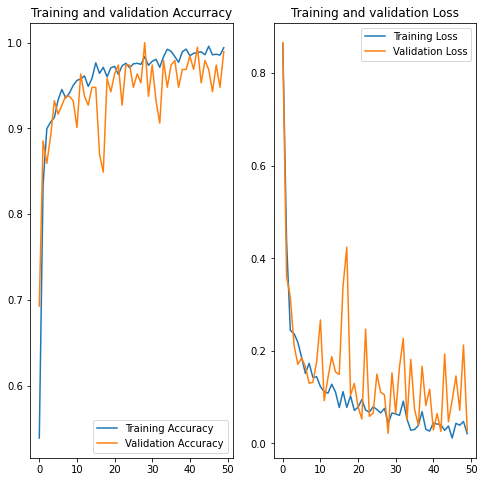

In [33]:
#x axis - epochs
plt.figure(figsize = (8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label = 'Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and validation Accurracy')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS), loss, label = 'Training Loss')
plt.plot(range(EPOCHS), val_loss, label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Training and validation Loss')
plt.show()

### Testing one one image 

First image to predict
actual label:  Potato___Late_blight
1/1 [==============================] - 1s 612ms/step
predicted label:  Potato___Late_blight


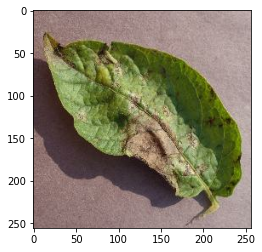

In [34]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    #tensor converted to numpy
    #plt.imshow(images_batch[0].numpy().astype('uint8')) 
    #print(images_batch[0].numpy().astype('uint8')) 3D array RGB
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    print("First image to predict")
    plt.imshow(first_image)
    print("actual label: ",class_names[first_label])
    #prediction for batch of 32 images
    batch_prediction = model.predict(images_batch)
    print("predicted label: ",class_names[np.argmax(batch_prediction[0])]) #for one image

In [35]:
""""def predict(model,img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[1].numpy())
    img_array = tf.expand_dims(img_array,0) #create a batch
    
    predictions = model.predict(img_array)
    
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100*(np.max(predictions[0])),2)
    return predicted_class, confidence #accuracy of prediction is 100%, confidence 100%"""

In [39]:
""""def predict(model, img_path):
    img = tf.keras.preprocessing.image.load_img(
        img_path, target_size=(IMAGE_SIZE, IMAGE_SIZE)
    )
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # create a batch

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * np.max(predictions[0]), 2)
    return predicted_class, confidence"""

In [40]:
""""predicted_class, confidence = predict(model, "my_image_LB1.jpg")
print(f"Predicted class: {predicted_class}")
print(f"Confidence: {confidence}%")"""

1/1 [==============================] - 0s 30ms/step
Predicted class: Potato___Early_blight
Confidence: 98.4%


In [41]:
predicted_class, confidence = predict(model, "my_image_LB2.jpg")
print(f"Predicted class: {predicted_class}")
print(f"Confidence: {confidence}%")

1/1 [==============================] - 0s 30ms/step
Predicted class: Potato___Late_blight
Confidence: 98.3%


In [42]:
predicted_class, confidence = predict(model, "my_image_h1.jpg")
print(f"Predicted class: {predicted_class}")
print(f"Confidence: {confidence}%")

1/1 [==============================] - 0s 31ms/step
Predicted class: Potato___healthy
Confidence: 99.93%


### Function for Inference and plotting the inference data

1/1 [==============================] - 0s 30ms/step


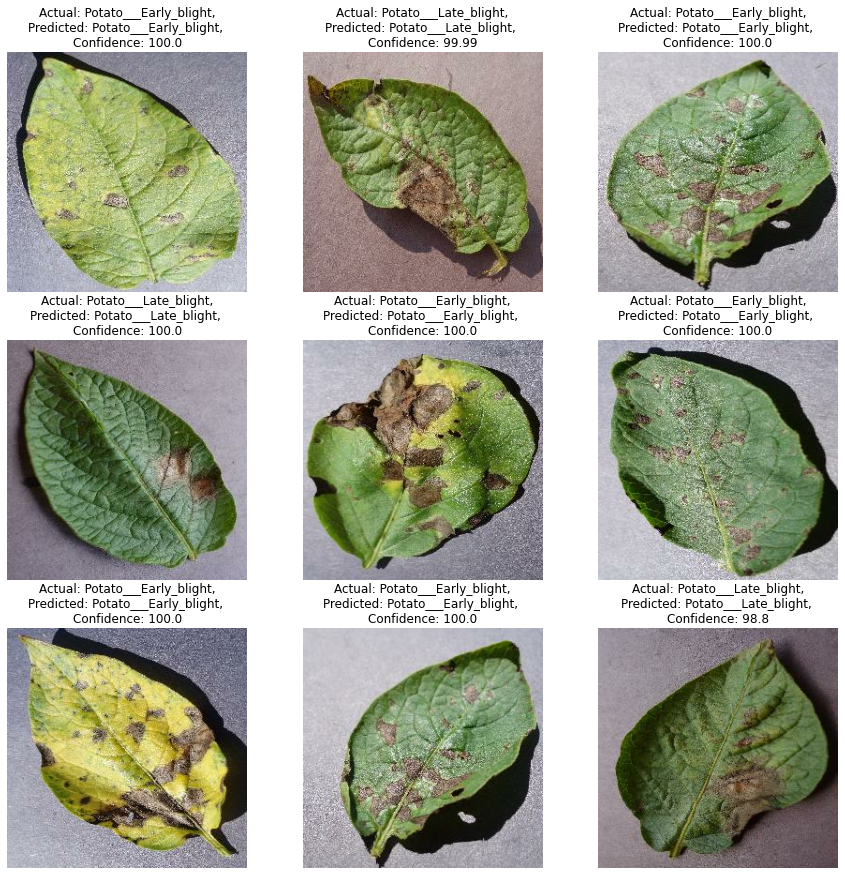

In [50]:
def predict(model, img_array):
    img = tf.keras.preprocessing.image.array_to_img(img_array)
    img = img.resize((256, 256))

    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # create a batch

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * np.max(predictions[0]), 2)
    return predicted_class, confidence

plt.figure(figsize=(15, 15))

for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        
        plt.title(f"Actual: {actual_class},\nPredicted: {predicted_class}, \nConfidence: {confidence}")
        
        plt.axis("off")

### Saving the Model
We append the model to the list of models as a new version

In [53]:
import os
model_version = max([int(i) for i in os.listdir("../models") + [0]])+1
model.save(f"../models/{model_version}.h5")

In [58]:
print(tf.__version__)

2.11.0
